# Division of project work tasks and responsibilities

###
### B227888, B222018 and B228274 are jointly responsible for parts 1, 2 and 3

# Introduce Main Topic
- This report focuses on the potential factors that affect tips amount and predicts the tips in a short future. 
- Firstly, we download the data for 12 months and cleanthe data. 
- Secondly, we analyse the data in three parts, namely the relation to regions, the relation to weather types and the prediction of tips amount. 
- The results might be useful for the drivers to maximise the profit and for the company to organize the taxi. 
- The analysis basically provides an expected tips income with respectto some factors like weather and time, which assists the taxi company in making rational use of taxi resources to obtain more tips.

    - Firstly, is the amount of tips affected by the pick-up location or the drop-off location?
    - Secondly, is the amount of tips impacted by various types of weather?
    - Thirdly, how to predict the tips in a short future based on the current data?
    - Fourthly, What variables affect the amount of tips?

postscript: Since data analysis needs to be adjusted according to different situations, we only wrote some of the code as functions.

In [2]:
import pandas as pd
import numpy as np

import shapefile

# To plot eographical map for Topic 3.1
import geopandas as gpd
import contextily as ctx

# To plot heat map for topic 3.2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# To get weather data for topic 3.2
from meteostat import  Hourly,  Stations
from datetime import datetime, timedelta

# To create time series for topic 3.3
from auto_ts import auto_timeseries

# Test of statistics for topic 3.4
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as sts 
import statsmodels.api as sm

# To ingnore all warning 
import warnings
warnings.filterwarnings('ignore')

# Import the function get_taxi_data() from utils.py
from utils import get_taxi_data

# To close the ssl
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


# 1.Downloading Data
- We download the data of 12 months in 2021, focusing on the variables 'tpep_dropoff_datetime',
- 'tpep_pickup_datetime','tip_amount','DOLocationID','PULocationID','payment_type'.

In [3]:
def download_data(year, months, taxi_type, N, Random_state, cols_to_read):
    '''
    To dowload data from NYC

    Input:
        year (str)
        months (list)
        taxi_type (str)
        N (int)
        Random_state (int)
        columns (list)

    Output:
        data (dataFrame): data from NYC
    '''
    data = pd.DataFrame()
    for i in months:
        month = get_taxi_data(year, i, taxi_type, save=True, columns=cols_to_read).sample(n=N, random_state=Random_state)
        data = pd.concat([data, month])
    return data


In [4]:
months = ['01', '02', '03', '04', '05',
          '06', '07', '08', '09', '10', '11', '12']
# To get data from year
year = '2021'
# Set the numbers of random sample
N = 5000
# Set the seed of random sample
Random_state = 1
taxi_type = 'yellow'
# To get the columns neeeded
cols_to_read = ['tpep_dropoff_datetime', 'tpep_pickup_datetime', 'tip_amount',
                'DOLocationID', 'PULocationID', 'payment_type',
                'trip_distance', 'passenger_count', 'total_amount'
                ]

# use function download_data to download data
data = download_data(year, months, taxi_type, N, Random_state, cols_to_read).reset_index(drop=True)
data


,tpep_dropoff_datetime,tpep_pickup_datetime,tip_amount,DOLocationID,PULocationID,payment_type,trip_distance,passenger_count,total_amount
0,2021-01-07 15:51:23,2021-01-07 15:46:29,0.75,236,236,1,0.60,1.0,9.05
1,2021-01-02 12:54:56,2021-01-02 12:39:25,0.00,231,170,1,3.30,1.0,16.30
2,2021-01-14 17:36:14,2021-01-14 17:29:39,1.08,263,236,1,1.11,3.0,11.88
3,2021-01-29 19:07:40,2021-01-29 19:04:04,1.86,229,140,1,0.87,1.0,11.16
4,2021-01-07 07:27:26,2021-01-07 07:21:10,0.00,166,238,1,1.61,1.0,10.30
...,...,...,...,...,...,...,...,...,...
59995,2021-12-31 08:41:29,2021-12-31 08:34:06,2.82,107,249,1,1.90,2.0,14.12
59996,2021-12-07 09:27:38,2021-12-07 09:22:23,1.76,164,79,1,0.94,1.0,10.56
59997,2021-12-17 18:18:58,2021-12-17 18:01:13,0.00,68,113,2,1.72,2.0,16.30
59998,2021-12-15 19:16:55,2021-12-15 18:58:10,3.45,137,229,1,2.30,0.0,20.75


# 2.Cleaning Data
- In this part, we aim to delete the data that paid by cash, as well as missing data and duplicateddata. 
- Afterwards, we remove the outliers by controlling three times of standard deviation.

In [5]:
# Print details about a DataFrame, such as the columns' non-null values, index dtype, and memory usage.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tpep_dropoff_datetime  60000 non-null  datetime64[ns]
 1   tpep_pickup_datetime   60000 non-null  datetime64[ns]
 2   tip_amount             60000 non-null  float64       
 3   DOLocationID           60000 non-null  int64         
 4   PULocationID           60000 non-null  int64         
 5   payment_type           60000 non-null  int64         
 6   trip_distance          60000 non-null  float64       
 7   passenger_count        56995 non-null  float64       
 8   total_amount           60000 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(3)
memory usage: 4.1 MB


In [6]:
# Generate descriptive statistics.
data.describe()

,tip_amount,DOLocationID,PULocationID,payment_type,trip_distance,passenger_count,total_amount
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,56995.000000,60000.000000
mean,2.271594,162.652483,165.255033,1.189883,4.154727,1.423809,19.330903
std,2.620069,70.626150,66.410767,0.534882,187.047490,1.037612,14.508094
min,-0.660000,1.000000,1.000000,0.000000,0.000000,0.000000,-98.420000
25%,0.000000,113.000000,132.000000,1.000000,1.080000,1.000000,11.630000
50%,2.000000,162.000000,162.000000,1.000000,1.800000,1.000000,14.800000
75%,3.000000,234.000000,234.000000,1.000000,3.260000,1.000000,20.800000
max,78.000000,265.000000,265.000000,4.000000,42161.350000,7.000000,282.800000


## 2.1 Handling Missing Data

In [7]:
# Check the Null in each columns
data.isnull().sum().sort_values(ascending=False)


passenger_count          3005
tpep_dropoff_datetime       0
tpep_pickup_datetime        0
tip_amount                  0
DOLocationID                0
PULocationID                0
payment_type                0
trip_distance               0
total_amount                0
dtype: int64

In [8]:
# drop na by any
data = data.dropna(how='any')
data


,tpep_dropoff_datetime,tpep_pickup_datetime,tip_amount,DOLocationID,PULocationID,payment_type,trip_distance,passenger_count,total_amount
0,2021-01-07 15:51:23,2021-01-07 15:46:29,0.75,236,236,1,0.60,1.0,9.05
1,2021-01-02 12:54:56,2021-01-02 12:39:25,0.00,231,170,1,3.30,1.0,16.30
2,2021-01-14 17:36:14,2021-01-14 17:29:39,1.08,263,236,1,1.11,3.0,11.88
3,2021-01-29 19:07:40,2021-01-29 19:04:04,1.86,229,140,1,0.87,1.0,11.16
4,2021-01-07 07:27:26,2021-01-07 07:21:10,0.00,166,238,1,1.61,1.0,10.30
...,...,...,...,...,...,...,...,...,...
59995,2021-12-31 08:41:29,2021-12-31 08:34:06,2.82,107,249,1,1.90,2.0,14.12
59996,2021-12-07 09:27:38,2021-12-07 09:22:23,1.76,164,79,1,0.94,1.0,10.56
59997,2021-12-17 18:18:58,2021-12-17 18:01:13,0.00,68,113,2,1.72,2.0,16.30
59998,2021-12-15 19:16:55,2021-12-15 18:58:10,3.45,137,229,1,2.30,0.0,20.75


## 2.2 Deleting Unnecessary or Irrelevant Values

In [9]:
# Tips are not recorded with cash payments, filter payments by payment type
data = data[data['payment_type'] != 2]
# Delete the nonpoitive tips amount
data = data[data['tip_amount'] > 0]
# Delete the nonpoitive trip_distance
data = data[data['trip_distance'] > 0]
# Delete the nonpoitive passenger_count
data = data[data['passenger_count'] > 0]
# Delete the nonpoitive total_amount
data = data[data['total_amount'] > 0]

# Reset the index
data = data.reset_index(drop=True)
data


,tpep_dropoff_datetime,tpep_pickup_datetime,tip_amount,DOLocationID,PULocationID,payment_type,trip_distance,passenger_count,total_amount
0,2021-01-07 15:51:23,2021-01-07 15:46:29,0.75,236,236,1,0.60,1.0,9.05
1,2021-01-14 17:36:14,2021-01-14 17:29:39,1.08,263,236,1,1.11,3.0,11.88
2,2021-01-29 19:07:40,2021-01-29 19:04:04,1.86,229,140,1,0.87,1.0,11.16
3,2021-01-08 23:23:13,2021-01-08 23:10:45,1.00,263,79,1,4.80,1.0,19.30
4,2021-01-25 22:17:24,2021-01-25 21:46:38,7.00,188,132,1,16.10,1.0,53.30
...,...,...,...,...,...,...,...,...,...
40390,2021-12-10 18:13:02,2021-12-10 18:03:48,2.36,140,237,1,1.37,1.0,14.16
40391,2021-12-02 19:41:12,2021-12-02 19:33:27,2.46,236,237,1,1.58,1.0,14.76
40392,2021-12-31 08:41:29,2021-12-31 08:34:06,2.82,107,249,1,1.90,2.0,14.12
40393,2021-12-07 09:27:38,2021-12-07 09:22:23,1.76,164,79,1,0.94,1.0,10.56


## 2.3 Managing Outliers 

In [10]:
def remove_outliers(df, columns, n_std):
    '''
    For given columns, remove outliers that are outside the standard deviation.

    Input:
        df (dataFrame): the dataframe that needed to clean
        columns (str): the name of columns that need to be cleared of data
        n_std (int): number of standard deviation
    Output:
        df (dataFrame): the datafram after cleaning
    '''

    # Check each value in given columns
    for col in columns:
        # Calculate the mean of each columns
        mean = df[col].mean()
        # Calculate the standard deviation of each columns
        sd = df[col].std()

        # Clean the data which greater than mean+(n_std*sd)
        df = df[(df[col] <= mean+(n_std*sd))]

    return df


In [11]:
# Apply the remove_outliers function to remove outliers
data = remove_outliers(
    data, ['tip_amount', 'trip_distance', 'passenger_count', 'total_amount'], 3)
# Reset the index
data = data.reset_index(drop=True)
data


,tpep_dropoff_datetime,tpep_pickup_datetime,tip_amount,DOLocationID,PULocationID,payment_type,trip_distance,passenger_count,total_amount
0,2021-01-07 15:51:23,2021-01-07 15:46:29,0.75,236,236,1,0.60,1.0,9.05
1,2021-01-14 17:36:14,2021-01-14 17:29:39,1.08,263,236,1,1.11,3.0,11.88
2,2021-01-29 19:07:40,2021-01-29 19:04:04,1.86,229,140,1,0.87,1.0,11.16
3,2021-01-08 23:23:13,2021-01-08 23:10:45,1.00,263,79,1,4.80,1.0,19.30
4,2021-01-07 13:57:34,2021-01-07 13:27:20,2.00,244,74,1,4.50,1.0,23.80
...,...,...,...,...,...,...,...,...,...
35898,2021-12-10 18:13:02,2021-12-10 18:03:48,2.36,140,237,1,1.37,1.0,14.16
35899,2021-12-02 19:41:12,2021-12-02 19:33:27,2.46,236,237,1,1.58,1.0,14.76
35900,2021-12-31 08:41:29,2021-12-31 08:34:06,2.82,107,249,1,1.90,2.0,14.12
35901,2021-12-07 09:27:38,2021-12-07 09:22:23,1.76,164,79,1,0.94,1.0,10.56


## 2.4. Feature Engineering
- Using domain expertise, feature engineering extracts features (characteristics, qualities, and attributes) from unprocessed data.
- In this column, we obtain the exact pick-up time from the original data. From the pick-up time,the corresponding date and corresponding hours are extracted, which are denoted by date and time, respectively.

In [12]:
# Change the type of 'tpep_pickup_datetime' to datetime
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
# The tpep_pickup_datetime of date-time time's component is changed to midnight
data['date'] = data['tpep_pickup_datetime'].dt.normalize()
# Get the hour of tpep_pickup_datetime
data['time'] = data['tpep_pickup_datetime'].dt.hour
# Calculate the dration(s)
data['duration'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']
data['duration'] = data['duration'] / np.timedelta64(1, 'm')
data


,tpep_dropoff_datetime,tpep_pickup_datetime,tip_amount,DOLocationID,PULocationID,payment_type,trip_distance,passenger_count,total_amount,date,time,duration
0,2021-01-07 15:51:23,2021-01-07 15:46:29,0.75,236,236,1,0.60,1.0,9.05,2021-01-07,15,4.900000
1,2021-01-14 17:36:14,2021-01-14 17:29:39,1.08,263,236,1,1.11,3.0,11.88,2021-01-14,17,6.583333
2,2021-01-29 19:07:40,2021-01-29 19:04:04,1.86,229,140,1,0.87,1.0,11.16,2021-01-29,19,3.600000
3,2021-01-08 23:23:13,2021-01-08 23:10:45,1.00,263,79,1,4.80,1.0,19.30,2021-01-08,23,12.466667
4,2021-01-07 13:57:34,2021-01-07 13:27:20,2.00,244,74,1,4.50,1.0,23.80,2021-01-07,13,30.233333
...,...,...,...,...,...,...,...,...,...,...,...,...
35898,2021-12-10 18:13:02,2021-12-10 18:03:48,2.36,140,237,1,1.37,1.0,14.16,2021-12-10,18,9.233333
35899,2021-12-02 19:41:12,2021-12-02 19:33:27,2.46,236,237,1,1.58,1.0,14.76,2021-12-02,19,7.750000
35900,2021-12-31 08:41:29,2021-12-31 08:34:06,2.82,107,249,1,1.90,2.0,14.12,2021-12-31,8,7.383333
35901,2021-12-07 09:27:38,2021-12-07 09:22:23,1.76,164,79,1,0.94,1.0,10.56,2021-12-07,9,5.250000


# 3.Data Analysis

Data analysis is the main part of the report. To further study the tips, three questions are asked:
- Firstly, is the amount of tips affected by the pick-up location or the drop-off location?
- Secondly, is the amount of tips impacted by various types of weather?
- Thirdly, how to predict the tips in a short future based on the current data?

## 3.1Tips VS Region
- By dividing the region into several blocks, we can discuss the tips amount by the pick-up block and the drop-off block? 
- This is a way to simplify the analysis and have a more straightforward observation of the relation between tips amount and the location by graphing. 
- This shows an expectation of tips amount in different areas, which might be beneficial for taxi drivers to predict and estimate the possible tips income.

In [13]:
# Reference
# Lines 11: GeoPandas Documents
# URL: https://geopandas.org/en/v0.5.0/projections.html

#  Read in the taxi zone shapefile
sf = gpd.read_file("Maps/taxi_zones/taxi_zones.shp")
# Read in the taxi zone csv
zone = pd.read_csv("Maps/taxi+_zone_lookup.csv")
# Get one of the most commonly used CRS is the WGS84 latitude-longitude projection
sf['geometry'] = sf['geometry'].to_crs(
    '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
sf


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((-73.85107 40.91037, -73.85207 40.909..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((-73.90175 40.76077, -73.90147 40.759..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((-74.01333 40.70503, -74.01327 40.704..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ..."


In [14]:
# Compute pickup and dropoff tips amount of each zone

# Reference
# Lines 15-16: GeoPandas Documents
# URL: https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_crs.html

# Compute the pickup location mean of tips amount througth groupby each zone
pu_zone = data.groupby(['PULocationID'], as_index=False).mean()[
    ['PULocationID', 'tip_amount']]
# Compute the dropoff location mean of tips amount througth groupby each zone
do_zone = data.groupby(['DOLocationID'], as_index=False).mean()[
    ['DOLocationID', 'tip_amount']]
# Add the tips amount by PULocationID index
pu_zone = gpd.GeoDataFrame(pd.merge(
    pu_zone, sf, left_on='PULocationID', right_on='LocationID')).drop('LocationID', axis=1)
# Add the tips amount by DOLocationID index
do_zone = gpd.GeoDataFrame(pd.merge(
    do_zone, sf, left_on='DOLocationID', right_on='LocationID')).drop('LocationID', axis=1)
# Geometric transformation to a new coordinate system by epsg=3857
pu_zone = pu_zone.to_crs(epsg=3857)
do_zone = do_zone.to_crs(epsg=3857)


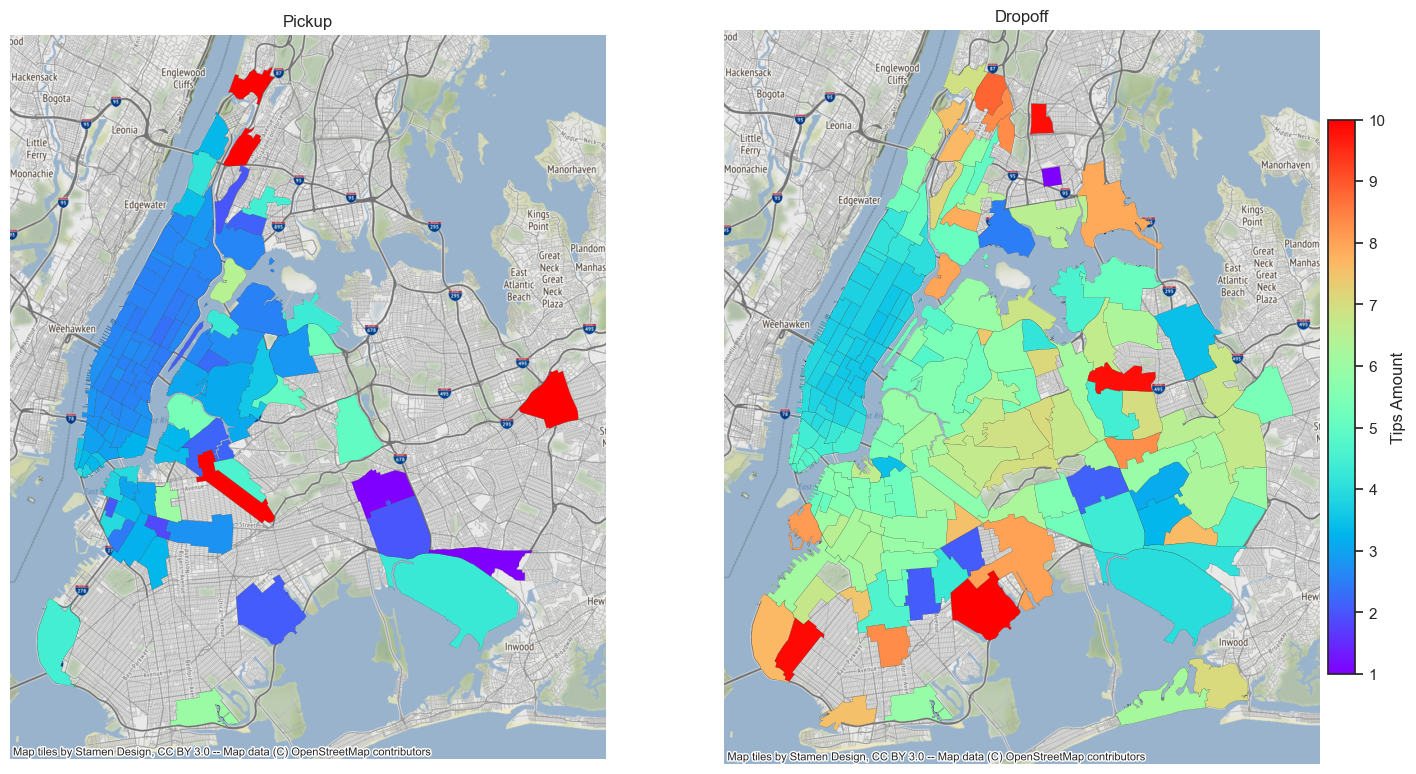

In [15]:
# Plot geospatial visualisation to compare pickup and dropoff amount from each zone

# Reference
# Lines 11, 13, 16, 18, 29: matplotlib and GeoPandas Documents
# URL: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# URL: https://contextily.readthedocs.io/en/latest/providers_deepdive.html
# URL: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html

# Set the size of figure
fig, axs = plt.subplots(ncols=2, figsize=(20, 10))

# Plot the subplot0 of pu_zone
axs[0] = pu_zone.plot(column='tip_amount', linewidth=0.09, edgecolor='k', figsize=(
    10, 10), cmap='rainbow', legend=False, ax=axs[0])
# Add a basemap of geometry zone
ctx.add_basemap(axs[0])

# Plot the subplot1 of do_zone
axs[1] = do_zone.plot(column='tip_amount', linewidth=0.1, edgecolor='k', figsize=(
    10, 10),  cmap='rainbow', legend=False, ax=axs[1])
# Add a basemap of geometry zone
ctx.add_basemap(axs[1])

# Add title
axs[0].set_title('Pickup')
axs[1].set_title('Dropoff')
# Turn the x- and y-axis off.
axs[0].set_axis_off()
axs[1].set_axis_off()
# Draw the color bar
patch_col = axs[0].collections[0]
cb = fig.colorbar(patch_col, ax=axs, shrink=0.72,
                  orientation="vertical", pad=0.005)
cb.ax.set_ylabel('Tips Amount')
plt.show()


### 3.1 Summary
- By observing the graph, it displays that the red areas are the pick-up(drop-off) areas that have the highest expectation of tips amount while the purple's are expected to have the lowest tips.
- The different regulation of pick-up graph and drop-off graph might reveal the city structure, and give the drivers an estimated tips income.

## 3.2 Tips VS Weather Type
- In this part, we discuss the relation between tips amount and 27 types of weather. We firstly solve the data by returning the longitude and latitude of location. 
- Secondly, the weather of a certain region is loaded by fixing the exact time. Finally, a graph is drawn, which can observe the relations explicitly.

### 3.2.1 Dealing with data

In [16]:
# Converting information about the region into latitude and longitude of the regional centre
sf['longitude'] = sf.centroid.x
sf['latitude'] = sf.centroid.y
sf


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",-74.174000,40.691831
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",-73.831299,40.616745
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",-73.847422,40.864473
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",-73.976968,40.723752
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",-74.188485,40.552659
...,...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((-73.85107 40.91037, -73.85207 40.909...",-73.852215,40.897932
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((-73.90175 40.76077, -73.90147 40.759...",-73.906306,40.744234
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((-74.01333 40.70503, -74.01327 40.704...",-74.013023,40.709138
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...",-73.946510,40.775932


In [17]:
# Add the longitude and latitude by LocationID index
data_Weather = pd.merge(data, sf[['LocationID', 'longitude', 'latitude']],
                        left_on='PULocationID', right_on='LocationID')
# data_Weather[['temp','dwpt','rhum','prcp','snow','wdir','wspd','wpgt','pres','tsun','coco']]=np.nan
# Create a new weather type columns
data_Weather['weather_type'] = np.nan
data_Weather


,tpep_dropoff_datetime,tpep_pickup_datetime,tip_amount,DOLocationID,PULocationID,payment_type,trip_distance,passenger_count,total_amount,date,time,duration,LocationID,longitude,latitude,weather_type
0,2021-01-07 15:51:23,2021-01-07 15:46:29,0.75,236,236,1,0.60,1.0,9.05,2021-01-07,15,4.900000,236,-73.957012,40.780436,NaN
1,2021-01-14 17:36:14,2021-01-14 17:29:39,1.08,263,236,1,1.11,3.0,11.88,2021-01-14,17,6.583333,236,-73.957012,40.780436,NaN
2,2021-01-06 20:00:38,2021-01-06 19:55:19,2.06,238,236,1,1.46,1.0,12.36,2021-01-06,19,5.316667,236,-73.957012,40.780436,NaN
3,2021-01-06 16:37:56,2021-01-06 16:25:46,2.86,141,236,1,1.78,2.0,17.16,2021-01-06,16,12.166667,236,-73.957012,40.780436,NaN
4,2021-01-11 13:44:14,2021-01-11 13:31:17,4.29,230,236,1,2.20,1.0,18.59,2021-01-11,13,12.950000,236,-73.957012,40.780436,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35677,2021-08-21 05:01:35,2021-08-21 04:36:17,2.00,142,80,1,7.02,1.0,29.80,2021-08-21,4,25.300000,80,-73.936793,40.715369,NaN
35678,2021-09-09 21:44:46,2021-09-09 21:28:35,4.46,210,14,1,6.47,1.0,26.76,2021-09-09,21,16.183333,14,-74.029892,40.624835,NaN
35679,2021-09-26 13:08:55,2021-09-26 12:43:39,6.47,48,194,1,6.58,1.0,38.82,2021-09-26,12,25.266667,194,-73.924596,40.791000,NaN
35680,2021-10-31 22:47:03,2021-10-31 22:35:17,2.46,227,106,1,2.34,1.0,14.76,2021-10-31,22,11.766667,106,-73.990647,40.673512,NaN


In [18]:
# Reference
# Lines 18-24 : Meteostat Documents
# URL: https://dev.meteostat.net/python/#installation

def get_weather(start_time, latitude, longitude):
    '''
        Get the weather type of a region based on its latitude and longitude.

    Input:
        start_time (datetime): the start time 
        latitude (float): the latitude of a region
        longitude (float): the longitude of a region

    Output:
        weather_data.coco[0] (int): the index of weather type
    '''
    # Get weather stations near given latitude and longitude
    stations = Stations()
    stations = stations.nearby(latitude, longitude)
    station = stations.fetch(3)
    # Get hourly data by one hour
    weather_data = Hourly(
        station.index.values[2], start_time, start_time + timedelta(hours=1))
    weather_data = weather_data.fetch()

    return weather_data.coco[0]


In [19]:
# Use get_weather function for each row
for i in range(len(data_Weather)):
    data_Weather['weather_type'][i] = get_weather(
        data_Weather['tpep_pickup_datetime'][i], data_Weather['latitude'][i], data_Weather['longitude'][i])
data_Weather


,tpep_dropoff_datetime,tpep_pickup_datetime,tip_amount,DOLocationID,PULocationID,payment_type,trip_distance,passenger_count,total_amount,date,time,duration,LocationID,longitude,latitude,weather_type
0,2021-01-07 15:51:23,2021-01-07 15:46:29,0.75,236,236,1,0.60,1.0,9.05,2021-01-07,15,4.900000,236,-73.957012,40.780436,2.0
1,2021-01-14 17:36:14,2021-01-14 17:29:39,1.08,263,236,1,1.11,3.0,11.88,2021-01-14,17,6.583333,236,-73.957012,40.780436,4.0
2,2021-01-06 20:00:38,2021-01-06 19:55:19,2.06,238,236,1,1.46,1.0,12.36,2021-01-06,19,5.316667,236,-73.957012,40.780436,2.0
3,2021-01-06 16:37:56,2021-01-06 16:25:46,2.86,141,236,1,1.78,2.0,17.16,2021-01-06,16,12.166667,236,-73.957012,40.780436,3.0
4,2021-01-11 13:44:14,2021-01-11 13:31:17,4.29,230,236,1,2.20,1.0,18.59,2021-01-11,13,12.950000,236,-73.957012,40.780436,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35677,2021-08-21 05:01:35,2021-08-21 04:36:17,2.00,142,80,1,7.02,1.0,29.80,2021-08-21,4,25.300000,80,-73.936793,40.715369,NaN
35678,2021-09-09 21:44:46,2021-09-09 21:28:35,4.46,210,14,1,6.47,1.0,26.76,2021-09-09,21,16.183333,14,-74.029892,40.624835,NaN
35679,2021-09-26 13:08:55,2021-09-26 12:43:39,6.47,48,194,1,6.58,1.0,38.82,2021-09-26,12,25.266667,194,-73.924596,40.791000,NaN
35680,2021-10-31 22:47:03,2021-10-31 22:35:17,2.46,227,106,1,2.34,1.0,14.76,2021-10-31,22,11.766667,106,-73.990647,40.673512,NaN


In [ ]:
# data_Weather.to_csv('weather_coco.csv')
# data_Weather = pd.read_csv('weather_coco.csv')
# data_Weather


In [20]:
# Check the Null in each columns
data_Weather.isnull().sum().sort_values(ascending=False)
# Drop the Null value in each rows
data_Weather = data_Weather.dropna(how='any')
# Reset the index
data_Weather = data_Weather.reset_index(drop=True)
data_Weather


,tpep_dropoff_datetime,tpep_pickup_datetime,tip_amount,DOLocationID,PULocationID,payment_type,trip_distance,passenger_count,total_amount,date,time,duration,LocationID,longitude,latitude,weather_type
0,2021-01-07 15:51:23,2021-01-07 15:46:29,0.75,236,236,1,0.60,1.0,9.05,2021-01-07,15,4.900000,236,-73.957012,40.780436,2.0
1,2021-01-14 17:36:14,2021-01-14 17:29:39,1.08,263,236,1,1.11,3.0,11.88,2021-01-14,17,6.583333,236,-73.957012,40.780436,4.0
2,2021-01-06 20:00:38,2021-01-06 19:55:19,2.06,238,236,1,1.46,1.0,12.36,2021-01-06,19,5.316667,236,-73.957012,40.780436,2.0
3,2021-01-06 16:37:56,2021-01-06 16:25:46,2.86,141,236,1,1.78,2.0,17.16,2021-01-06,16,12.166667,236,-73.957012,40.780436,3.0
4,2021-01-11 13:44:14,2021-01-11 13:31:17,4.29,230,236,1,2.20,1.0,18.59,2021-01-11,13,12.950000,236,-73.957012,40.780436,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26626,2021-05-22 15:10:20,2021-05-22 15:02:19,5.00,138,83,1,3.70,1.0,18.30,2021-05-22,15,8.016667,83,-73.892173,40.738323,3.0
26627,2021-07-19 13:51:13,2021-07-19 13:42:28,2.00,229,193,1,2.40,1.0,15.30,2021-07-19,13,8.750000,193,-73.941997,40.760313,3.0
26628,2021-08-09 10:02:43,2021-08-09 09:52:07,0.04,226,193,1,1.62,4.0,9.84,2021-08-09,9,10.600000,193,-73.941997,40.760313,4.0
26629,2021-12-13 14:27:23,2021-12-13 14:09:27,3.35,141,193,1,2.40,1.0,20.15,2021-12-13,14,17.933333,193,-73.941997,40.760313,3.0


In [21]:
# Reference
# Lines : Meteostat Documents
# URL: https://dev.meteostat.net/formats.html#meteorological-data-units

# Create a dictionary with a weather type index corresponding to the weather type
weather_dic = {1: "Clear", 2: "Fair", 3: 'Cloudy',
               4: "Overcast", 5: "Fog", 6: 'Freezing_Fog',
               7: "Light_Rain", 8: "Rain", 9: 'Heavy_Rain',
               10: "Freezing_Rain", 11: "Heavy_Freezing_Rain", 12: 'Sleet',
               13: "Heavy_Sleet", 14: "Light_Snowfall", 15: 'Snowfall',
               16: "Heavy_Snowfall", 17: "Rain_Shower", 18: 'Heavy_Rain_Shower',
               19: "Sleet_Shower", 20: "Heavy_Sleet_Shower", 21: 'Snow_Shower',
               22: "Heavy_Snow_Shower", 23: "Lightning", 24: 'Hail',
               25: "Thunderstorm", 26: "Heavy_Thunderstorm", 27: 'Storm'
               }


In [22]:
# Replace the weather index by weather dictionary
data_Weather['cha_weather_type'] = data_Weather['weather_type']
data_Weather = data_Weather.replace({"cha_weather_type": weather_dic})
data_Weather


,tpep_dropoff_datetime,tpep_pickup_datetime,tip_amount,DOLocationID,PULocationID,payment_type,trip_distance,passenger_count,total_amount,date,time,duration,LocationID,longitude,latitude,weather_type,cha_weather_type
0,2021-01-07 15:51:23,2021-01-07 15:46:29,0.75,236,236,1,0.60,1.0,9.05,2021-01-07,15,4.900000,236,-73.957012,40.780436,2.0,Fair
1,2021-01-14 17:36:14,2021-01-14 17:29:39,1.08,263,236,1,1.11,3.0,11.88,2021-01-14,17,6.583333,236,-73.957012,40.780436,4.0,Overcast
2,2021-01-06 20:00:38,2021-01-06 19:55:19,2.06,238,236,1,1.46,1.0,12.36,2021-01-06,19,5.316667,236,-73.957012,40.780436,2.0,Fair
3,2021-01-06 16:37:56,2021-01-06 16:25:46,2.86,141,236,1,1.78,2.0,17.16,2021-01-06,16,12.166667,236,-73.957012,40.780436,3.0,Cloudy
4,2021-01-11 13:44:14,2021-01-11 13:31:17,4.29,230,236,1,2.20,1.0,18.59,2021-01-11,13,12.950000,236,-73.957012,40.780436,4.0,Overcast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26626,2021-05-22 15:10:20,2021-05-22 15:02:19,5.00,138,83,1,3.70,1.0,18.30,2021-05-22,15,8.016667,83,-73.892173,40.738323,3.0,Cloudy
26627,2021-07-19 13:51:13,2021-07-19 13:42:28,2.00,229,193,1,2.40,1.0,15.30,2021-07-19,13,8.750000,193,-73.941997,40.760313,3.0,Cloudy
26628,2021-08-09 10:02:43,2021-08-09 09:52:07,0.04,226,193,1,1.62,4.0,9.84,2021-08-09,9,10.600000,193,-73.941997,40.760313,4.0,Overcast
26629,2021-12-13 14:27:23,2021-12-13 14:09:27,3.35,141,193,1,2.40,1.0,20.15,2021-12-13,14,17.933333,193,-73.941997,40.760313,3.0,Cloudy


### 3.2.2 Plot The Graph

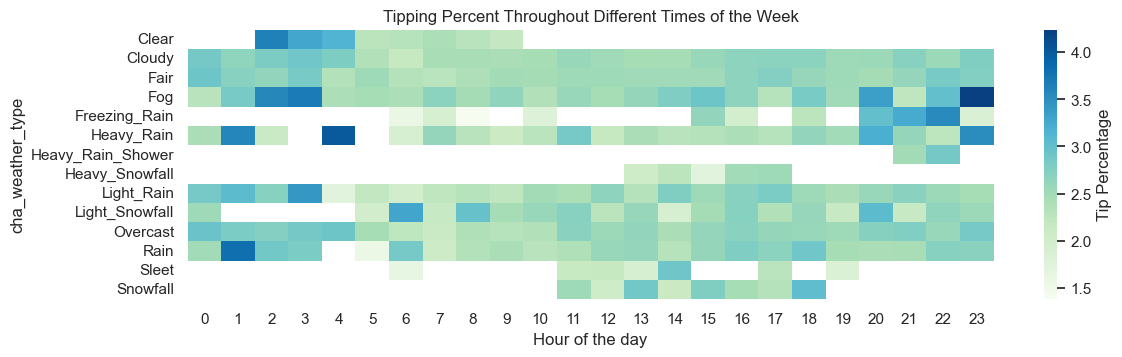

In [23]:
# Compute the tipping percentage in each hour through the week

# Reference
# Lines 10，13 : seaborn Documents
# URL: https://seaborn.pydata.org/generated/seaborn.heatmap.html

# Calculate the mean of tip amounts through groupby weather type
tip_weather = data_Weather.groupby(['cha_weather_type', 'time'], as_index=False)[
    'tip_amount'].mean()
# Sorting by value of time
tip_weather = tip_weather.sort_values(
    ['cha_weather_type', 'time']).reset_index(drop=True)
# Create a spreadsheet-style pivot table as a DataFrame
tip_weather_heatmap = pd.pivot_table(
    tip_weather, values='tip_amount', index='cha_weather_type', columns='time')

# Set the figure size
fig, ax = plt.subplots(figsize=(13, 3.5))
# Plot rectangular data as a color-encoded matrix.
sns.heatmap(tip_weather_heatmap, cbar_kws={
            'label': 'Tip Percentage'}, ax=ax, cmap='GnBu')
# Set x and y label and title
ax.set_ylabel('cha_weather_type')
ax.set_xlabel('Hour of the day')
ax.set_title('Tipping Percent Throughout Different Times of the Week')
plt.show()


### 3.2 Summary
- From this graph, we can observe that only 14 types of weather have ever happened in New York City.
- The deeper the color is, the more tips are given. Therefore, the drivers got the highest tips at 5-6am in heavy rain on average while those who served at 3-4pm in heavy snowfall got the lowest.
- In some specific weather types like cloudly, the tips amount are not so related to the time in a day.

## 3.3Tips Prediction
After analysing the region and weather type, we now would like to see the prediction of tips in the short-term future based on the past-time data.

<AxesSubplot: title={'center': 'tips & time'}, xlabel='date'>

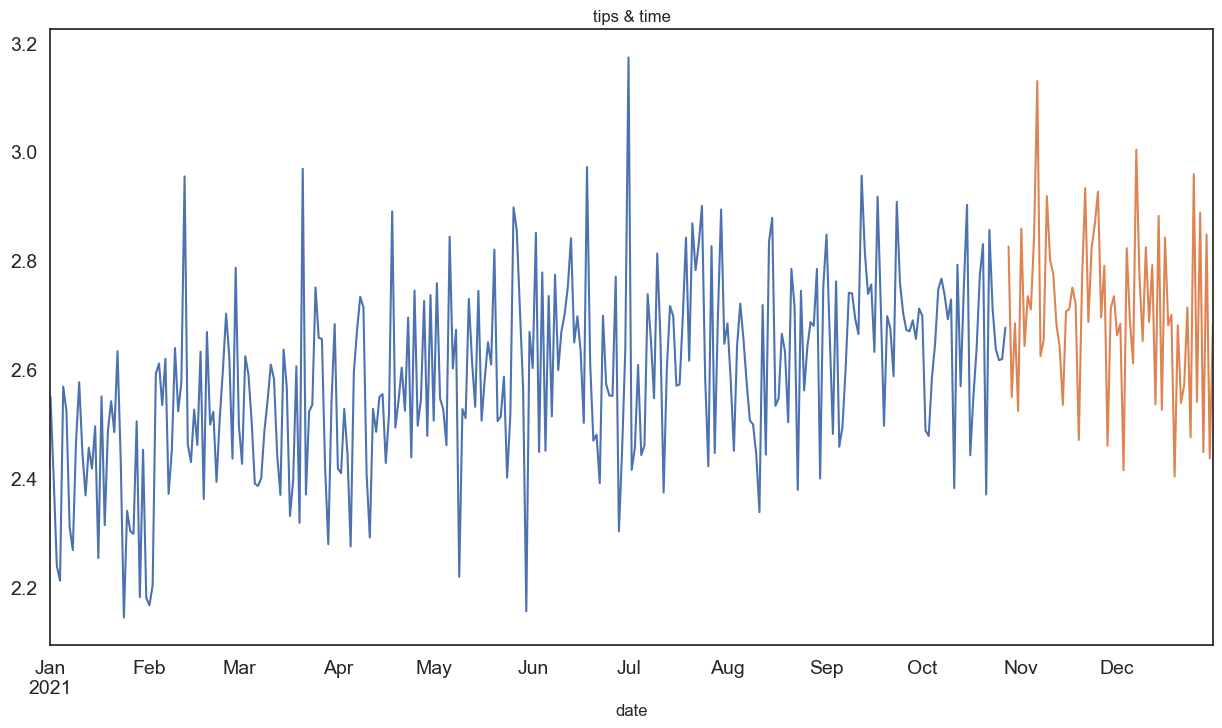

In [24]:
# Calculate the mean of tip amounts through groupby date
time_Tip = pd.DataFrame(data.groupby(['date']).mean()['tip_amount'])

# Set the training and testing data
train_df = time_Tip.iloc[:300]
test_df = time_Tip.iloc[300:]

# Plot the training and testing data
train_df.tip_amount.plot(
    figsize=(15, 8), title='tips & time', fontsize=14, label='Train')
test_df.tip_amount.plot(
    figsize=(15, 8), title='tips & time', fontsize=14, label='Test')


### 3.3 Description
- It seems that the trend of tips amount has a dramatic fluctuation but the overall tendency is increasing with the time. 
- The blue lines are the data we based while the orange ones are what we predict.

Start of Fit.....
    Target variable given as = tip_amount
Start of loading of data.....
    Inputs: ts_column = date, sep = ,, target = ['tip_amount']
    Using given input: pandas dataframe...
    train time series date column is the index on test data...
    train data shape = (300, 1)
Alert: Could not detect strf_time_format of date. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Data is already stationary
There is no differencing needed in this datasets for VAR model
    No time series plot since verbose = 0. Continuing
Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
kwargs for Prophet model: {'iter': 100.0}
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expa

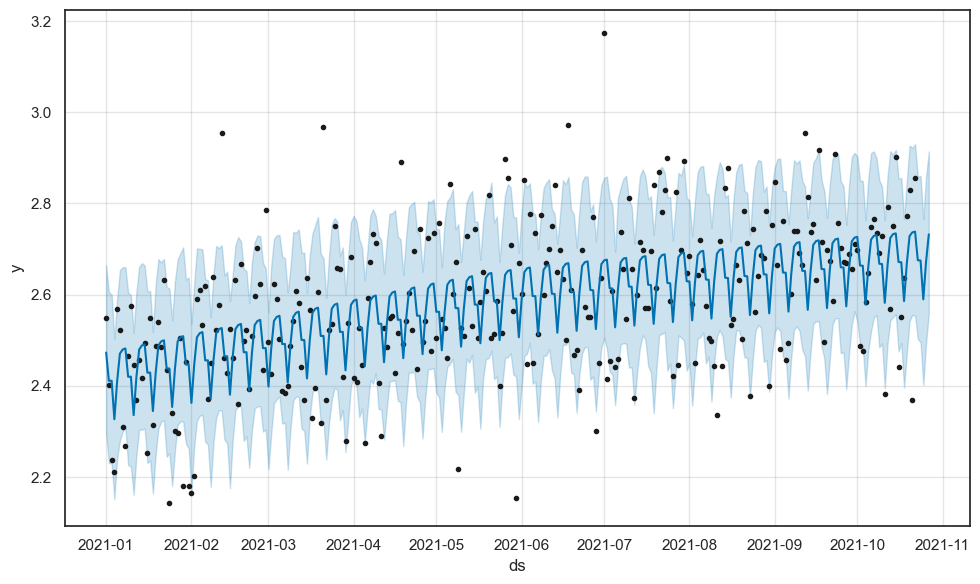

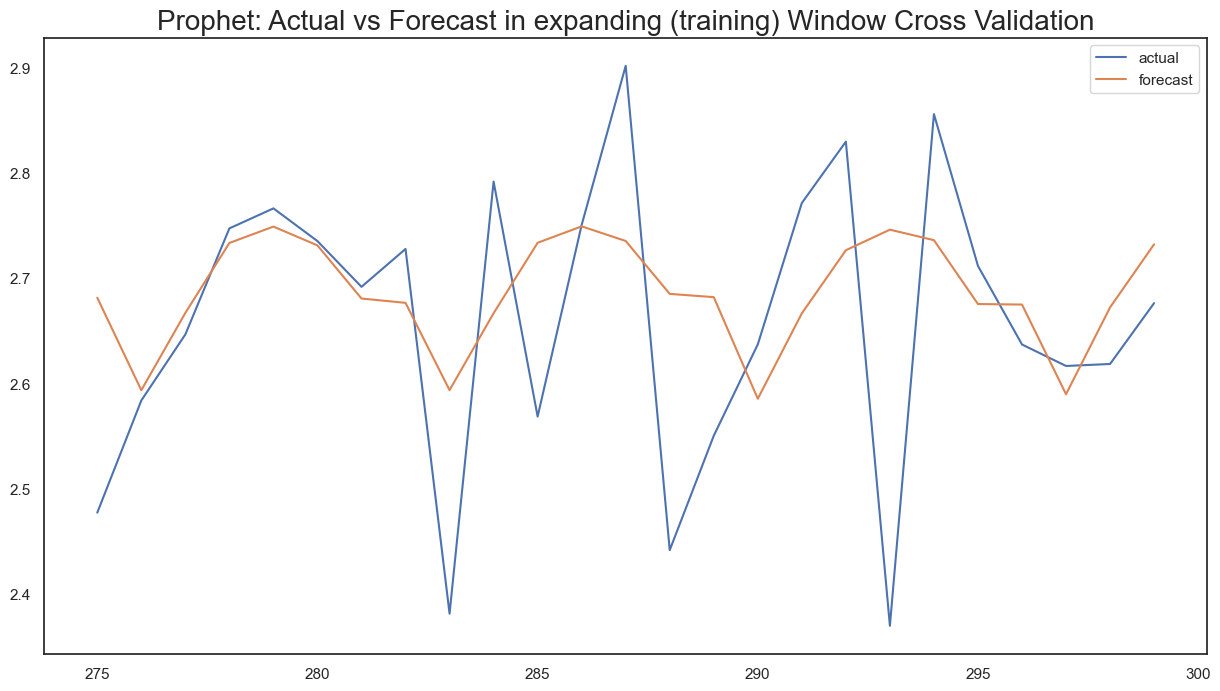

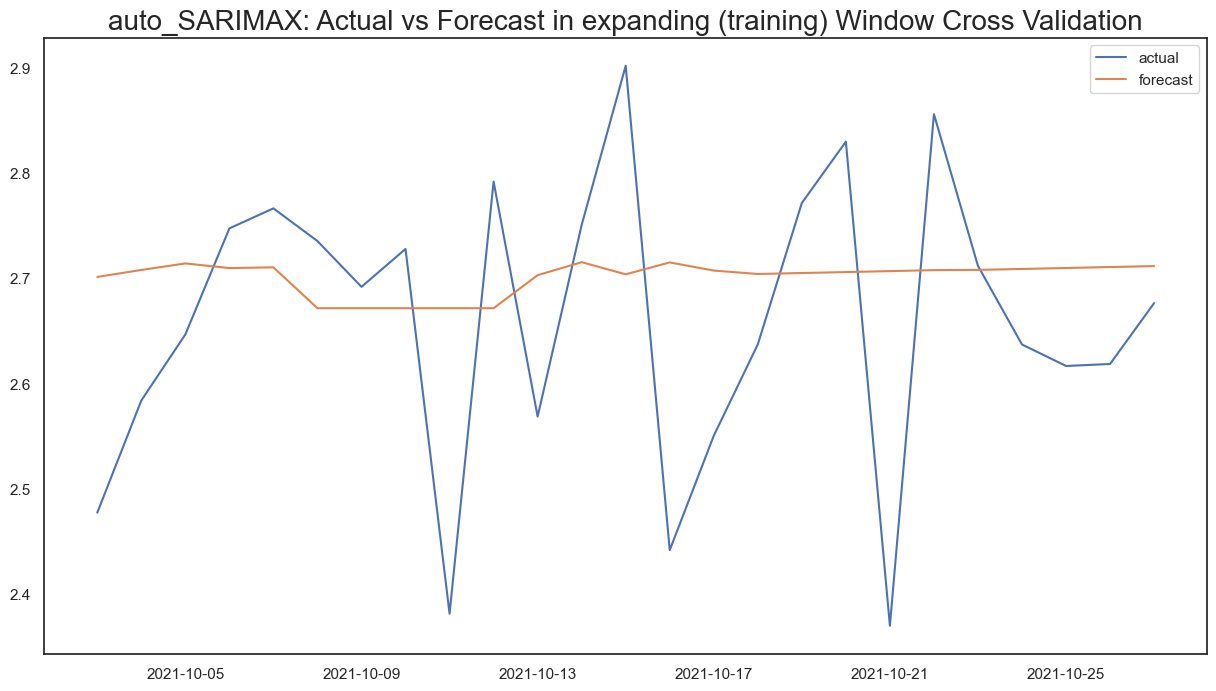

In [25]:
# Reference
# Lines 6，8 : AutoTS Documents
# URL: https://winedarksea.github.io/AutoTS/build/html/source/tutorial.html

# Use auto_timeseries to analyse and predict
model = auto_timeseries( score_type='rmse', time_interval='D', model_type='best')
# fit the auto_timeseries model
model.fit(traindata= train_df,ts_column="date",target="tip_amount")

### 3.3 Summary
- Auto is a package that five models in machine learning are used. 
- From the result, it is apparent that tips increase by steps, which coincides with the previous conclusion that tips amount increases by time.

## 3.4 Exploring Tips with linear regression OLS
- This part explores whether tips is related to other variables
- We first select the variables initially by correlation coefficient
- Then we use OLS to make judgements and do some statistical tests 

In [28]:
# Calculating correlation
correlation_matrix = data_Weather.loc[:, ['tip_amount', 'duration', 'weather_type',
                                          'longitude', 'latitude', 'total_amount', 'passenger_count', 'trip_distance']].corr()
print(correlation_matrix)


                 tip_amount  duration  weather_type  longitude  latitude  \
tip_amount         1.000000  0.080697     -0.006988   0.039815 -0.036751   
duration           0.080697  1.000000     -0.001757   0.001123 -0.003210   
weather_type      -0.006988 -0.001757      1.000000   0.001596  0.005279   
longitude          0.039815  0.001123      0.001596   1.000000  0.625627   
latitude          -0.036751 -0.003210      0.005279   0.625627  1.000000   
total_amount       0.779270  0.123850     -0.013491   0.082861 -0.037531   
passenger_count    0.002759  0.000050     -0.002360  -0.014391 -0.007489   
trip_distance      0.627344  0.101754     -0.001210   0.138753 -0.029265   

                 total_amount  passenger_count  trip_distance  
tip_amount           0.779270         0.002759       0.627344  
duration             0.123850         0.000050       0.101754  
weather_type        -0.013491        -0.002360      -0.001210  
longitude            0.082861        -0.014391       0.1387

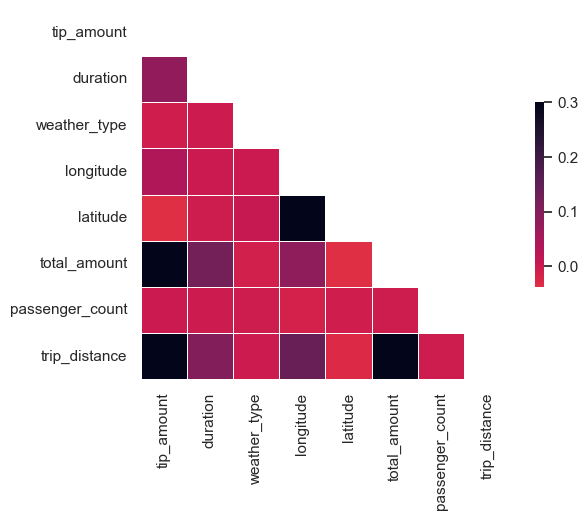

In [29]:
# Exclude duplicate correlations by masking uper right values;triu(): Upper triangle of an array. #Add diverging colormap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
# Draw correlation plot, color map option can be found https://seaborn.pydata.org/tutorial/color_palettes.html
sns.heatmap(correlation_matrix, mask=mask, cmap="rocket_r", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}) 
plt.show()

### 3.4.1 Correlation
- By observing the correlation coefficient, I select the parameter whose correlation coefficient is greater than 0.05

In [30]:
X = data_Weather[['trip_distance', 'total_amount']]
Y = data_Weather['tip_amount']
# add intercept, default option goes without intercept
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print_model = model.summary()
print(print_model)


                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                 2.545e+04
Date:                Sun, 04 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:34:37   Log-Likelihood:                -28698.
No. Observations:               26631   AIC:                         5.740e+04
Df Residuals:                   26628   BIC:                         5.743e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.8584      0.018    -47.161

### 3.4.2 OLS
The results of the test show that both distance trip and total amount have a significant effect on the tips amount, as their p-values are both less than 0.05

In [31]:
# white test
white_test = het_white(model.resid,  model.model.exog)

# define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value',
          'F-Statistic', 'F-Test p-value']

# print results of White's test
print(dict(zip(labels, white_test)))


{'Test Statistic': 2644.960168650412, 'Test Statistic p-value': 0.0, 'F-Statistic': 587.192091612189, 'F-Test p-value': 0.0}


### 3.4.3 White’s test
White’s test is used to test for heteroscedastic errors in regression analysis. We can see that the p-value is less than 0.05 and therefore passes the check.

In [32]:
# Durbin-Watson statistic
Residuals= model.resid
#compare Durbin-Watson statistic with 2. If Durbin-Watson statistic is close to 2, then accept the null hypothesis that residuals are independent.
print('Durbin-Watson statistic is ', durbin_watson(Residuals))

Durbin-Watson statistic is  1.98372150086534


### 3.4.4 Durbin-Watson
The Durbin-Watson (DW) statistic tests autocorrelation in the residuals from a statistical model or regression analysis. The p-value is less than 0.05 and therefore passes the test.

p-value of Chi-squared goodness of fit test is 0.0
null hypothesis for group online should be reject, as p-value < 5% 


Text(0.5, 0, 'Value of Residual')

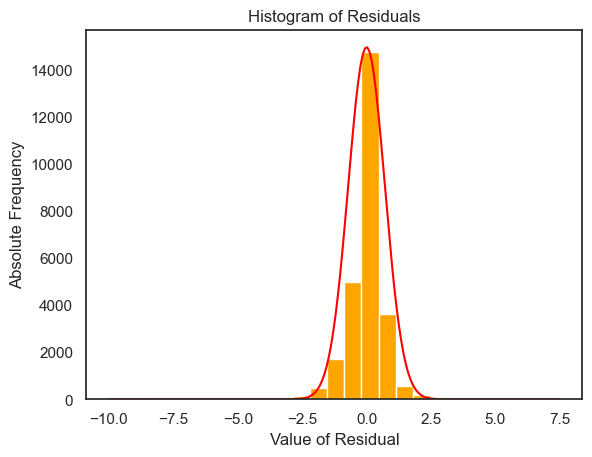

In [33]:
#Normality of residuals: residuals are normally distributed

# Reference
# Lines : Course of Python Data Analysis

mean_Residuals=np.mean(Residuals)
#ddof is delta degree of freedom, ddof=1: using sample mean formula mean_G[0,0]= np.mean(Group1) var_G[0,0]= np.var(Group1,ddof=1)
var_Residuals=np.var(Residuals,ddof=1) 

#Cutoffs for those bins can be found via the inverse function of CDF #21 bins require 20 cutoffs.

Bin_Cutoff=np.zeros(20)

#all bins have equal probabilities, the sum is 1. 
for i in range(20):
    Bin_Cutoff[i]=sts.norm.ppf((i+1)/21,loc=mean_Residuals,scale=np.sqrt(var_Residuals))

Expected_Relative_Freq=1/21*np.ones(21)

#Compute the observed absolute frequency for each bin by counting the number of sample points in each bin 
Observed_Absolute_Freq=np.zeros(21)

Observed_Absolute_Freq[0]=len(np.where(Residuals <= Bin_Cutoff[0])[0]) 
for i in range(1,20):
    Observed_Absolute_Freq[i]=len(np.where(Residuals <= Bin_Cutoff[i])[0])-np.sum(Observed_Absolute_Freq[0:i])

Observed_Absolute_Freq[20]=len(Residuals)-np.sum(Observed_Absolute_Freq[0:21])
Expected_Absolute_Freq=Expected_Relative_Freq*len(Residuals)
print('p-value of Chi-squared goodness of fit test is', sts.chisquare(Observed_Absolute_Freq,Expected_Absolute_Freq,ddof=2)[1]) 
#print('null hypothesis for group online should be retained, as p-value> 5% ')
print('null hypothesis for group online should be reject, as p-value < 5% ')

#Alternatively, generate a histogram to check this, the histogram can be integrated with a PDF curve
plt.hist(Residuals, bins= 20, color='Orange')
pltx=np.linspace(-10,7.5,200)
plt.plot(pltx,len(Residuals)*sts.norm.pdf(pltx,loc=mean_Residuals,scale=np.sqrt(var_Residuals)),color='red')
plt.title('Histogram of Residuals')
plt.ylabel('Absolute Frequency')
plt.xlabel('Value of Residual')

### 3.4.5 Residuals test
From the graph and the p-value it can be seen that the residuals conform to a normal distribution and therefore pass the check

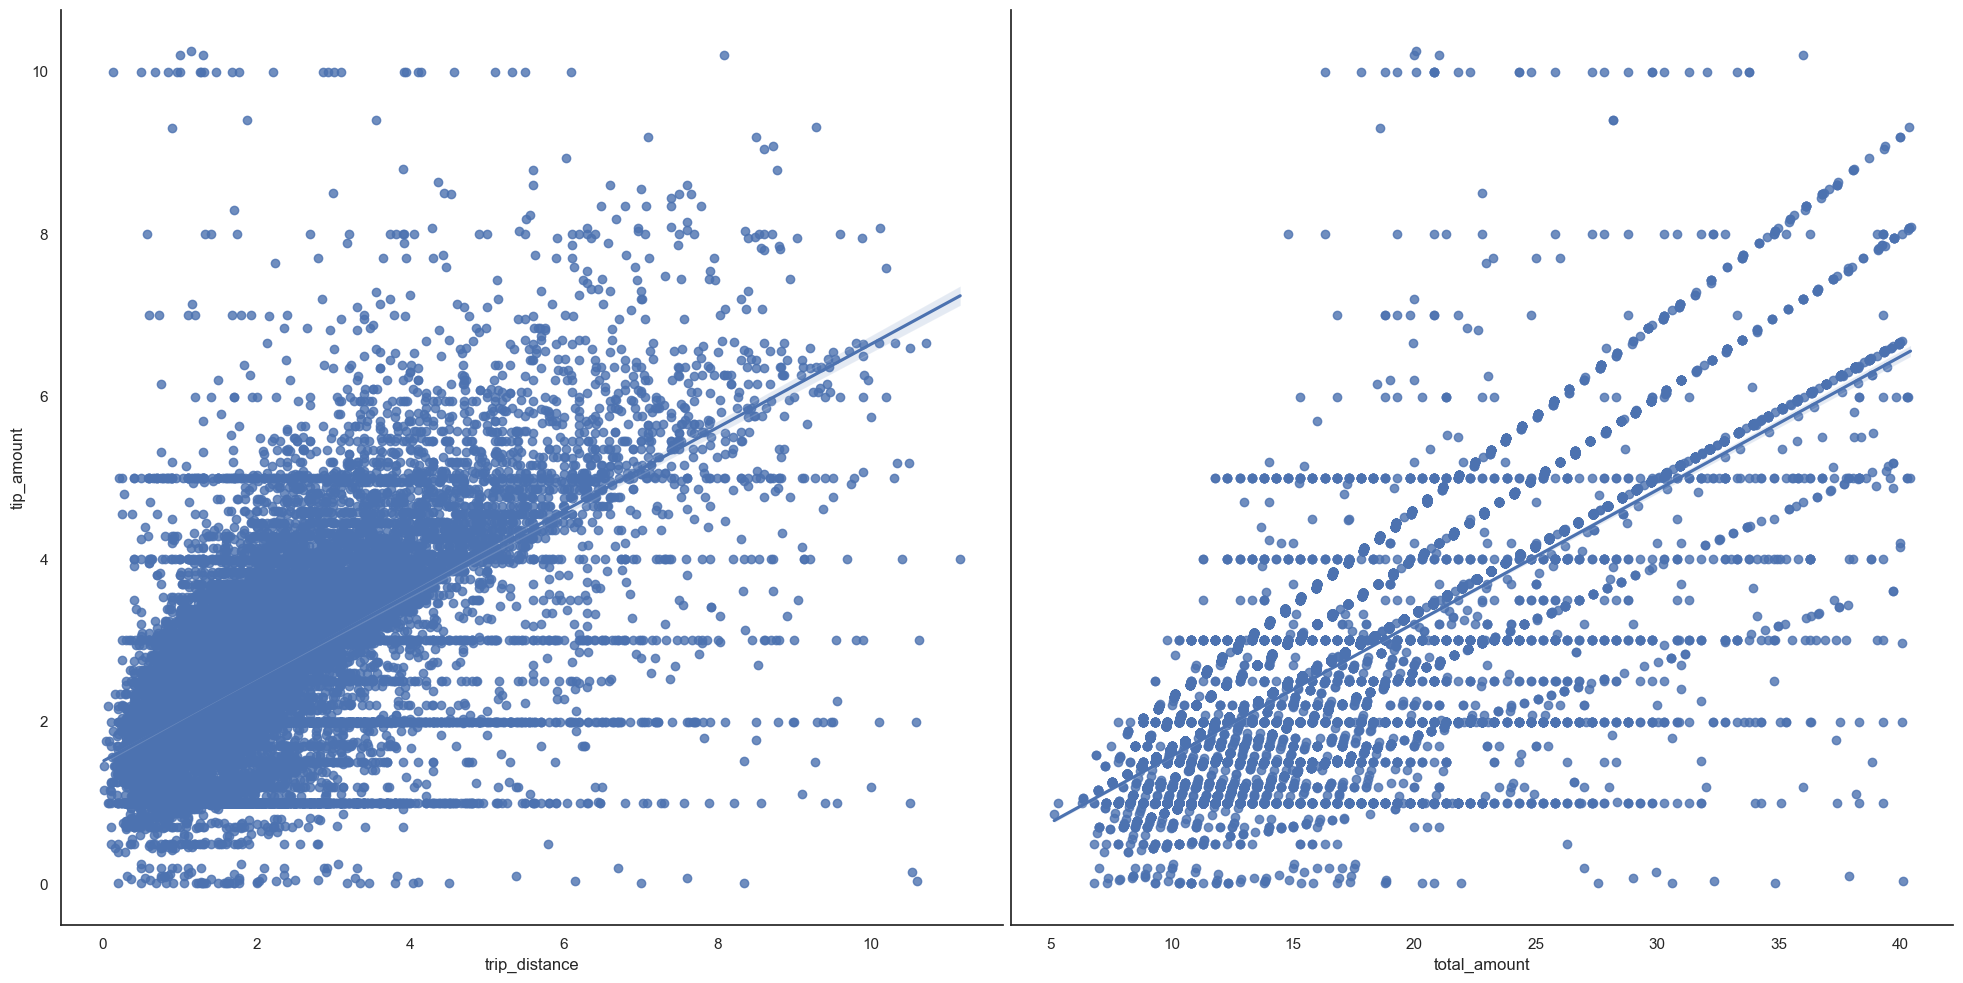

In [34]:
# plot of OLS
sns.pairplot(data_Weather, x_vars=['trip_distance', 'total_amount'], y_vars='tip_amount', kind='reg', height=10, aspect=1)
plt.show()

### 3.4 Summary
From the linear regression(OLS) , the check and the pictures show that the amount of tips is related to the distance and the total amount.

## 3.5 Conclusion
- In conclusion, the company or driver can have an expected tips income when they know the pick-up location and drop-off location. 
- In addition, the weather as well as the corresponding time in a day sometimes could be a reliable data to refer to. 
- Moreover, based on the previous data, the future tips income are predicted to be increased fluctuately, which allows companies to have a positive forecast.
- What's more, amount of tips is related to the distance and the total amount.